# **Import Library**

In [ ]:
# library untuk menangani data
import zipfile
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Dropout
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# --- Library untuk Manipulasi dan Analisis Data ---
import os
import re
import numpy as np
import pandas as pd
import zipfile

# --- Library untuk Visualisasi ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Library untuk Pemrosesan Teks ---
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec

# Unduh resource NLTK yang diperlukan
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# --- Library untuk Machine Learning ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, cohen_kappa_score, classification_report

# --- Library untuk Deep Learning ---
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Layer,Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Lambda, TextVectorization
)
from tensorflow.keras import saving
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Cek versi library
print("TensorFlow:", tf.__version__)

TensorFlow: 2.17.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load dataset

In [ ]:
# Path ke file zip di Google Drive
zip_path = '/content/drive/MyDrive/Colab Notebooks/CAPSTONE PROJECT BANGKIT/DATASET/learning-agency-lab-automated-essay-scoring-2.zip'
extract_path = '/content/dataset'

# Mengekstrak file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Memastikan bahwa file telah diekstrak
extracted_files = os.listdir(extract_path)
print("Files in extracted folder:", extracted_files)

# Cek apakah file yang dibutuhkan ada sebelum memuatnya
train_file = os.path.join(extract_path, 'train.csv')
test_file = os.path.join(extract_path, 'test.csv')
sample_submission_file = os.path.join(extract_path, 'sample_submission.csv')

if all(os.path.exists(file) for file in [train_file, test_file, sample_submission_file]):
    # Membaca dataset yang diekstraksi
    train = pd.read_csv(train_file)
    test = pd.read_csv(test_file)
    sample_submission = pd.read_csv(sample_submission_file)


Files in extracted folder: ['test.csv', 'sample_submission.csv', 'train.csv']


# **Exploratory Data Analysis**

## Informasi Dataset

{test/train}.csv
* essay_id: Pengenal unik untuk setiap esai.
* full_text: Teks esai.
* score: Skor esai dengan rentang 1-6.

sample_submission.csv : Sampel valid yang dimasukkan untuk prediksi.  

In [ ]:
print('train data shape:', train.shape )
train.head()

train data shape: (17307, 3)


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [ ]:
train.describe()

,score
count,17307.000000
mean,2.948402
std,1.044899
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,6.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


In [ ]:
train.isnull().sum()

,0
essay_id,0
full_text,0
score,0


In [ ]:
print('test data shape:', test.shape )
test.head()

test data shape: (3, 2)


,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [ ]:
test.isnull().sum()

,0
essay_id,0
full_text,0


In [ ]:
sample_submission.head()

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4


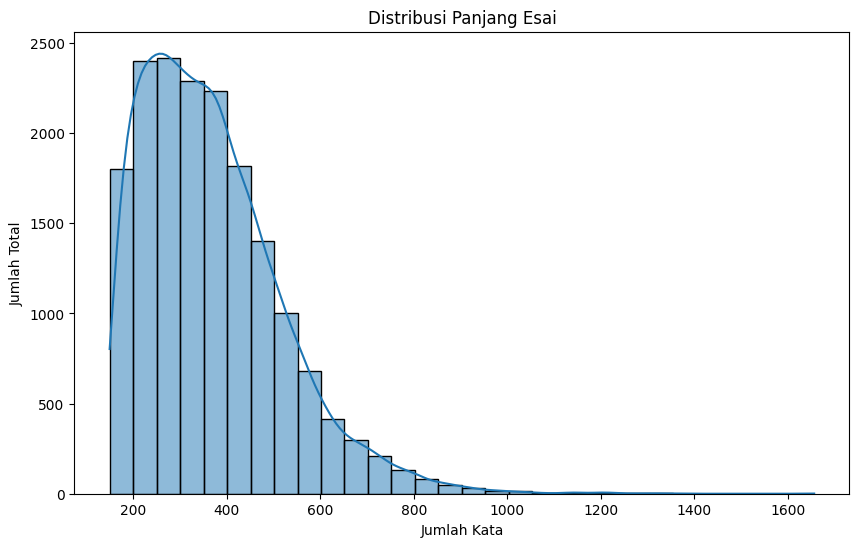

In [ ]:
# Menghitung panjang esai berdasarkan jumlah kata yang dipisahkan oleh spasi dalam setiap teks.
essay_lengths = train['full_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(essay_lengths, bins=30, kde=True)
plt.title('Distribusi Panjang Esai')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Total')
plt.show()

In [ ]:
# Hitung jumlah kata pada setiap esai
essay_lengths = train['full_text'].apply(lambda x: len(x.split()))

print(f"Minimum Panjang Esai: {essay_lengths.min()} kata")
print(f"Maximum Panjang Esai: {essay_lengths.max()} kata")
print(f"Rata-rata Panjang Esai: {essay_lengths.mean():.2f} kata")
print(f"Median Panjang Esai: {essay_lengths.median()} kata")
print(f"25th Persentil: {essay_lengths.quantile(0.25)} kata")
print(f"50th Persentil (Median): {essay_lengths.quantile(0.50)} kata")
print(f"75th Persentil: {essay_lengths.quantile(0.75)} kata")

Minimum Panjang Esai: 150 kata
Maximum Panjang Esai: 1656 kata
Rata-rata Panjang Esai: 368.35 kata
Median Panjang Esai: 345.0 kata
25th Persentil: 253.0 kata
50th Persentil (Median): 345.0 kata
75th Persentil: 452.0 kata


<ipython-input-28-17e5cb8ffaec>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=train, palette='viridis')


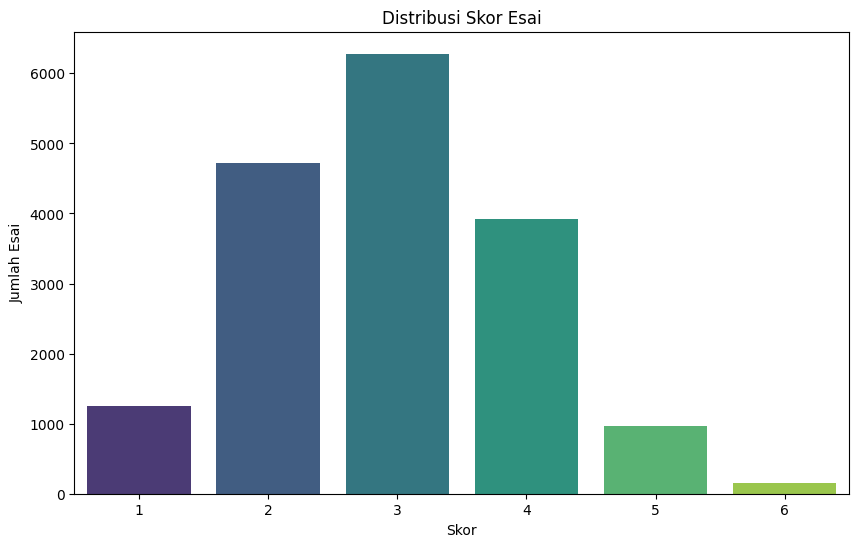

In [ ]:
# Distribusi skor esai
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=train, palette='viridis')
plt.title('Distribusi Skor Esai')
plt.xlabel('Skor')
plt.ylabel('Jumlah Esai')
plt.show()

In [ ]:
train['score'].value_counts()

,count
score,
3,6280
2,4723
4,3926
1,1252
5,970
6,156


In [ ]:
train['full_text'].head()

,full_text
0,Many people have car where they live. The thin...
1,I am a scientist at NASA that is discussing th...
2,People always wish they had the same technolog...
3,"We all heard about Venus, the planet without a..."
4,"Dear, State Senator\n\nThis is a letter to arg..."


# **Preprocessing Data**

In [ ]:
# Membersihkan teks
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

In [ ]:
# Implementasi pembersihan teks
train['clean_text'] = train['full_text'].apply(clean_text)
test['clean_text'] = test['full_text'].apply(clean_text)

In [ ]:
train['clean_text'].value_counts()

,count
clean_text,
venus is worthy place to study but dangerous the reaosn in doing theis is because of the challenge there is trying to study something with out going for yourself that is pretty hard to do one you have the biuld something that will either help your or something that can with so the temputure of venus two the distance of getting there and back gotta have something to hold that uch fuel to go there and come home if a human is going you need to have a food stock for them to last of the planet just like when they sent a robot to the planet it had to out a material tthat can withstand the planet itself but that only lasted two weeks now they are try to go for longer the two weeks in conclusion i know that tcan do it its just going to take some time for it to happen,1
many people have car where they live the thing they dont know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in vaubangermany they dont have that proble because 70 percent of vaubans families do not own carsand 57 percent sold a car to move there street parkig driveways and home garages are forbidden on the outskirts of freiburd that near the french and swiss borders you probaly wont see a car in vaubans streets because they are completely car free but if some that lives in vauban that owns a car ownership is allowedbut there are only two places that you can park a large garages at the edge of the developmentwhere a car owner buys a space but it not cheap to buy one they sell the space for you car for 40000 along with a home the vauban people completed this in 2006 they said that this an example of a growing trend in europethe untile states and some where else are suburban life from auto use this is called smart planning the current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in europe and up to 50 percent in some car intensive in the united states i honeslty think that good idea that they did that is vaudan because that makes cities denser and better for walking and in vauban there are 5500 residents within a rectangular square mile in the artical david gold berg said that all of our development since world war 2 has been centered on the carsand that will have to change and i think that was very true what david gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in vauban so people can see how we really dont need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car it good that they are doing that if you thik about your help the earth in way and thats a very good thing to in the united states the environmental protection agency is promoting what is called car reducedcommuntuntiesand the legislators are starting to actif cautiously maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year in previous bill80 percent of appropriations have by law gone to highways and only 20 percent to other transports there many good reason why they should do this,1
i am a scientist at nasa that is discussing the face on mars i will be explaining how the face is a land form by sharing my information about this isue i will tell you just that first off how could it be a martions drawing there is no plant life on mars as of rite now that we know of which means so far as we know it is not possible for any type of life that explains how it could not be made by martians also why and how would a martion build a face so big it just does not make any since that a martian did this next why it is a landform there are many landforms that are

In [ ]:
# Tokenisasi teks menjadi kata-kata
train_tokens = [word_tokenize(text) for text in train['clean_text']]
test_tokens = [word_tokenize(text) for text in test['clean_text']]

In [ ]:
# Melatih model Word2Vec
model_w2v = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Fungsi untuk mendapatkan vektor rata-rata kata
def get_average_word2vec(tokens_list, model, vector_size):
    vec = np.zeros(vector_size)
    valid_words = 0
    for word in tokens_list:
        if word in model.wv:
            vec += model.wv[word]
            valid_words += 1
    if valid_words > 0:
        vec /= valid_words
    return vec

In [ ]:
# Menyusun fitur teks dengan vektor rata-rata Word2Vec
X_train_w2v = np.array([get_average_word2vec(tokens, model_w2v, 100) for tokens in train_tokens])
X_test_w2v = np.array([get_average_word2vec(tokens, model_w2v, 100) for tokens in test_tokens])

In [ ]:
# Target variable: the score (1-6)
y_train = train['score'].values

# **Modelling Data**

In [ ]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from gensim.models import Word2Vec

In [ ]:
# Membagi data
y_train = train['score'].values  # Target variable
X_train, X_val, y_train, y_val = train_test_split(X_train_w2v, y_train, test_size=0.2, random_state=42)

In [ ]:
# Tentukan path untuk menyimpan model terbaik di Google Drive
checkpoint_path = '/content/drive/MyDrive/checkpoints/best_model.keras'

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

# Memuat model jika sudah ada atau membuat baru
try:
    model = load_model(checkpoint_path)
    print("Model loaded successfully.")
except:
    model = Sequential([
        # Convolution Layer untuk ekstraksi fitur lokal
        Conv1D(128, 5, activation='relu', input_shape=(100, 1)),  # Conv1D untuk ekstraksi fitur lokal
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(256, 5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Flatten(),

        Dense(512, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001)),
        PReLU(),
        BatchNormalization(),
        Dropout(0.4),

        Dense(256, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001)),
        PReLU(),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001)),
        PReLU(),
        BatchNormalization(),
        Dropout(0.4),

        Dense(64, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001)),
        PReLU(),
        BatchNormalization(),

        Dense(7, activation='softmax')  # Jumlah kelas output
    ])
    print("New model created.")

# Kompilasi model dengan optimizer yang lebih baik
optimizer = Adam(learning_rate=0.0005)  # Learning rate sedikit lebih besar
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks untuk pelatihan
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

# Melatih model dengan 100 epoch
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint, reduce_lr],
    verbose=1
)

# Evaluasi model dengan metrics tambahan
from sklearn.metrics import classification_report
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred.argmax(axis=1)))

Model loaded successfully.
Epoch 1/100
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5260 - loss: 1.1065
Epoch 1: val_loss improved from inf to 1.20514, saving model to /content/drive/MyDrive/checkpoints/best_model.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5260 - loss: 1.1066 - val_accuracy: 0.4812 - val_loss: 1.2051 - learning_rate: 5.0000e-04
Epoch 2/100
425/433 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5226 - loss: 1.1130
Epoch 2: val_loss improved from 1.20514 to 1.20251, saving model to /content/drive/MyDrive/checkpoints/best_model.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5225 - loss: 1.1131 - val_accuracy: 0.4858 - val_loss: 1.2025 - learning_rate: 5.0000e-04
Epoch 3/100
426/433 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5171 - loss: 1.1238
Epoch 3: val_loss improved from 1.20251 to 1.20188, saving model to /content/drive/MyDrive/checkpoints/best_model.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5171 - loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import cohen_kappa_score

# Evaluasi model pada data validasi
y_val_pred = model.predict(X_val)  # Prediksi probabilitas
y_val_pred = y_val_pred.argmax(axis=1)  # Ambil kelas dengan probabilitas tertinggi

# Cohen's Kappa untuk evaluasi
kappa_score = cohen_kappa_score(y_val, y_val_pred, weights='quadratic')
print("Cohen's Kappa Score (Validation):", kappa_score)


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Cohen's Kappa Score (Validation): 0.6148406013257195


In [ ]:
# Load dataset test
test_path = '/content/drive/MyDrive/Colab Notebooks/CAPSTONE PROJECT BANGKIT/DATASET/test.csv'
df_test = pd.read_csv(test_path)

# Clean text in test dataset
df_test['clean_text'] = df_test['full_text'].apply(clean_text)

# Tokenize test data
test_tokens = [word_tokenize(text) for text in df_test['clean_text']]

# Transform text data using Word2Vec (vector averaging)
X_test_new = np.array([get_average_word2vec(tokens, model_w2v, 100) for tokens in test_tokens])

# Make predictions with the neural network model
y_pred_test_nn = model.predict(X_test_new).argmax(axis=1)  # Prediksi kelas dengan probabilitas tertinggi

# Show predictions
df_test['predicted_score'] = y_pred_test_nn
print(df_test[['full_text', 'predicted_score']].head())  # Show sample predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
                                           full_text  predicted_score
0  Many people have car where they live. The thin...                1
1  I am a scientist at NASA that is discussing th...                3
2  People always wish they had the same technolog...                4


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np

# Fungsi untuk membersihkan dan mengubah teks menjadi vektor menggunakan Word2Vec
def clean_and_prepare_input(input_text, w2v_model, vector_size):
    """
    Membersihkan teks dan mengubahnya ke representasi Word2Vec.
    Args:
        input_text (str): Teks yang akan diuji.
        w2v_model (Word2Vec): Model Word2Vec yang sudah dilatih.
        vector_size (int): Ukuran vektor Word2Vec.
    Returns:
        np.array: Representasi vektor dari teks yang sudah diproses (1D untuk model DNN).
    """
    # Bersihkan teks
    cleaned_text = clean_text(input_text)

    # Tokenisasi teks
    tokens = word_tokenize(cleaned_text)

    # Dapatkan rata-rata vektor Word2Vec
    text_vector = get_average_word2vec(tokens, w2v_model, vector_size)

    # Kembalikan input dalam bentuk 2D untuk model DNN
    return np.expand_dims(text_vector, axis=0)  # (1, vector_size)

# Fungsi untuk menguji model dengan teks langsung
def test_with_input_text(input_text):
    """
    Menggunakan model untuk memprediksi skor dari teks yang diberikan.
    Args:
        input_text (str): Teks esai yang akan diuji.
    Returns:
        tuple: Skor prediksi asli dan skor yang dibulatkan (dalam rentang [1, 6]).
    """
    # Bersihkan dan siapkan teks
    prepared_input = clean_and_prepare_input(input_text, model_w2v, vector_size=100)

    # Prediksi dengan model
    predicted_score = model.predict(prepared_input)  # Gunakan model yang sesuai (bukan model LSTM)

    # Menyimpan nilai asli prediksi
    raw_predicted_score = predicted_score[0][0]

    # Membulatkan hasil prediksi ke integer terdekat dan memastikan rentang [1, 6]
    rounded_predicted_score = np.rint(raw_predicted_score).astype(int)
    rounded_predicted_score = np.clip(rounded_predicted_score, 1, 6)  # Pastikan skor di antara 1 dan 6

    return raw_predicted_score, rounded_predicted_score  # Kembalikan nilai asli dan dibulatkan

# Fungsi untuk menampilkan input teks dan mendapatkan hasil prediksi
def show_input_box_and_predict():
    # Membuat text area dan tombol submit
    input_text_widget = widgets.Textarea(
        value='',
        placeholder='Masukkan teks esai di sini...',
        description='Teks Esai:',
        disabled=False,
        layout=widgets.Layout(width='100%', height='200px')
    )
    submit_button = widgets.Button(
        description="Submit",
        button_style="success",  # Warna tombol
        tooltip="Klik untuk memprediksi skor",
        icon="check"
    )
    output_area = widgets.Output()  # Area output untuk menampilkan hasil

    # Fungsi untuk menangani klik tombol submit
    def on_submit_clicked(b):
        with output_area:
            clear_output()  # Hapus output sebelumnya
            input_text = input_text_widget.value.strip()
            if input_text:
                raw_score, rounded_score = test_with_input_text(input_text)
                print("Raw Predicted Score:", raw_score)
                print("Rounded Predicted Score:", rounded_score)
            else:
                print("Masukkan teks terlebih dahulu.")

    # Kaitkan tombol dengan fungsi
    submit_button.on_click(on_submit_clicked)

    # Tampilkan widget
    display(input_text_widget, submit_button, output_area)

# Menampilkan input box untuk memasukkan teks
show_input_box_and_predict()


Textarea(value='', description='Teks Esai:', layout=Layout(height='200px', width='100%'), placeholder='Masukka…

Button(button_style='success', description='Submit', icon='check', style=ButtonStyle(), tooltip='Klik untuk me…

Output()

In [ ]:
import os
from google.colab import files

# Tentukan folder untuk menyimpan final model
final_model_folder = '/content/drive/MyDrive/Colab Notebooks/CAPSTONE PROJECT BANGKIT/final_model_2'

# Buat folder jika belum ada
os.makedirs(final_model_folder, exist_ok=True)

# Path untuk menyimpan final model
final_model_path = os.path.join(final_model_folder, 'final_model_2.h5')

# Menyimpan model dalam format .h5
model.save(final_model_path)  # Menggunakan objek model yang sudah dilatih
print(f"Final model berhasil disimpan pada {final_model_path}")

# Menyediakan opsi unduh file model
files.download(final_model_path)


Final model berhasil disimpan pada /content/drive/MyDrive/Colab Notebooks/CAPSTONE PROJECT BANGKIT/final_model_2/final_model_2.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
from google.colab import files

# Tentukan folder untuk menyimpan final model TFLite
tflite_model_folder = '/content/drive/MyDrive/Colab Notebooks/CAPSTONE PROJECT BANGKIT/final_model_2_tflite'

# Buat folder jika belum ada
os.makedirs(tflite_model_folder, exist_ok=True)

# Path untuk menyimpan file TFLite
tflite_model_path = os.path.join(tflite_model_folder, 'final_model_2.tflite')

# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # Model neural network Anda
tflite_model = converter.convert()

# Menyimpan model TFLite ke file
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model TFLite berhasil disimpan pada {tflite_model_path}")

# Menyediakan opsi unduh file model TFLite
files.download(tflite_model_path)

Saved artifact at '/tmp/tmpu_789phi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  133656165127568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133656164192800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133656163150032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133656163151792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133656163147920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133656163150560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133656163148096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133656162730576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133656162738848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133656162732512: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model TFLite berhasil dis

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>